# Efficient Inference

## Intent Detection

In [15]:
from transformers import pipeline

bert_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"
pipe = pipeline("text-classification", model=bert_ckpt, device=0)

In [16]:
query = """Hey, I'd like to rent a vehicle from Nov 1st to Nov 15th in Paris and I need a 15 passenger van"""
pipe(query)

[{'label': 'car_rental', 'score': 0.5490034222602844}]

## Performance Benchmark

In [3]:
import torch
from pathlib import Path
import numpy as np

In [13]:
from time import perf_counter


class PerformanceBenchMark:
    def __init__(self, pipeline, dataset, optim_type="BERT baseline"):
        self.pipeline = pipeline
        self.dataset = dataset
        self.optim_type = optim_type
    
    def compute_accuracy(self):
        preds, labels = [], []
        for example in self.dataset:
            pred = self.pipeline(example["text"])[0]["label"]
            label = example["intent"]
            preds.append(intents.str2int(pred))
            labels.append(label)
        accuracy = accuracy_score.compute(predictions=preds, references=labels)
        print(f"Accuracy on test set - {accuracy['accuracy']:.3f}")
        return accuracy
    
    def compute_size(self):
        state_dict = self.pipeline.model.state_dict()
        tmp_path = Path("data/model.pt")
        torch.save(state_dict, tmp_path)
        size_mb = Path(tmp_path).stat().st_size / (1024 * 1024)
        tmp_path.unlink()
        print(f"Model size (MB) - {size_mb:.2f}")
        return {"size_mb": size_mb}

    def time_pipeline(self, query="What is the pin number for my account?"):
        latencies = []
        for _ in range(10):
            _ = self.pipeline(query)
        for _ in range(100):
            start_time = perf_counter()
            _ = self.pipeline(query)
            latency = perf_counter() - start_time
            latencies.append(latency)
        
        time_avg_ms = 1000 * np.mean(latencies)
        time_std_ms = 1000 * np.std(latencies)
        print(f"Average latency (ms) - {time_avg_ms:.2f} +\- {time_std_ms:.2f}")
        return {"time_avg_ms": time_avg_ms, "time_std_ms": time_std_ms}


    def run_benchmark(self):
        metrics = {}
        metrics[self.optim_type] = self.compute_size()
        metrics[self.optim_type].update(self.time_pipeline())
        #metrics[self.optim_type].update(self.compute_accuracy())
        return metrics

In [5]:
from datasets import load_dataset
clinc = load_dataset("/home/guhangsong/Data/huggingface/clinc_oos", "plus", ignore_verifications=True)

Reusing dataset clinc_oos (/home/guhangsong/.cache/huggingface/datasets/clinc_oos/plus/1.0.0/aeddd4060bedd3ac78e70c84f136f930a3827295b4cefb62a3430d007cea91d7)


  0%|          | 0/3 [00:00<?, ?it/s]

In [7]:
sample = clinc["test"][42]
sample

{'text': 'transfer $100 from my checking to saving account', 'intent': 133}

In [8]:
intents = clinc["test"].features["intent"]
intents.int2str(sample["intent"])

'transfer'

In [9]:
import evaluate
accuracy_score = evaluate.load("accuracy")

In [10]:
list(pipe.model.state_dict().items())[42]

('bert.encoder.layer.2.attention.self.value.weight',
 tensor([[-1.0526e-02, -3.2215e-02,  2.2097e-02,  ..., -6.0953e-03,
           4.6521e-03,  2.9844e-02],
         [-1.4964e-02, -1.0915e-02,  5.2396e-04,  ...,  3.2047e-05,
          -2.6890e-02, -2.1943e-02],
         [-2.9640e-02, -3.7842e-03, -1.2582e-02,  ..., -1.0917e-02,
           3.1152e-02, -9.7786e-03],
         ...,
         [-1.5116e-02, -3.3226e-02,  4.2063e-02,  ..., -5.2652e-03,
           1.1093e-02,  2.9703e-03],
         [-3.6809e-02,  5.6848e-02, -2.6544e-02,  ..., -4.0114e-02,
           6.7487e-03,  1.0511e-03],
         [-2.4961e-02,  1.4747e-03, -5.4271e-02,  ...,  2.0004e-02,
           2.3981e-02, -4.2880e-02]]))

In [20]:
from time import perf_counter

for _ in range(3):
    start_time = perf_counter()
    _ = pipe(query)
    latency = perf_counter() - start_time
    print(f"Latency (ms) - {1000 * latency:.3f}")

Latency (ms) - 115.146
Latency (ms) - 28.346
Latency (ms) - 16.803


/opt/miniconda3/envs/pytorch/lib/python3.9/site-packages/transformers/pipelines/base.py:1036: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [21]:
pb = PerformanceBenchMark(pipe, clinc["test"])
perf_metrics = pb.run_benchmark()

Model size (MB) - 418.17
Average latency (ms) - 6.40 +\- 0.93
Accuracy on test set - 0.867


In [20]:
sample

{'text': 'transfer $100 from my checking to saving account', 'intent': 133}

In [21]:
sample['intent']

133

In [23]:
pipe(sample["text"])[0]["label"]

'transfer'

## Knowledge Distillation

In [28]:
from transformers import TrainingArguments

class DistillationTrainingArguments(TrainingArguments):
    def __init__(self, *args, alpha=0.5, temperature=2.0, **kwargs):
        super().__init__(*args, **kwargs)
        self.alpha = alpha
        self.temperature = temperature

In [29]:
import torch.nn as nn
import torch.nn.functional as F
from transformers import Trainer

class DistillationTrainer(Trainer):
    def __init__(self, *args, teacher_model=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.teacher_model = teacher_model
    
    def compute_loss(self, model, inputs, return_outputs=False):
        outputs_stu = model(**inputs)
        loss_ce = outputs_stu.loss
        logits_stu = outputs_stu.logits
        with torch.no_grad():
            outputs_tea = self.teacher_model(**inputs)
            logits_tea = outputs_tea.logits
        loss_fct = nn.KLDivLoss(reduction="batchmean")
        loss_kd = self.args.temperature ** 2 * loss_fct(
            F.log_softmax(logits_stu / self.args.temperature, dim=-1),
            F.softmax(logits_tea / self.args.temperature, dim=-1))
        loss = self.args.alpha * loss_ce + (1. - self.args.alpha) * loss_kd
        return (loss, outputs_stu) if return_outputs else loss

In [40]:
from transformers import AutoTokenizer

student_ckpt = "distilbert-base-uncased"
student_tokenizer = AutoTokenizer.from_pretrained(student_ckpt)

def tokenize_text(batch):
    return student_tokenizer(batch["text"], truncation=True)

clinc_enc = clinc.map(tokenize_text, batched=True, remove_columns=["text"])
clinc_enc = clinc_enc.rename_column("intent", "labels")

Parameter 'function'=<function tokenize_text at 0x7f2338ddf550> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/16 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

In [31]:
def compute_metrics(pred):
    predictions, labels = pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy_score.compute(predictions=predictions, references=labels)

In [42]:
batch_size = 48

finetuned_ckpt = "distilbert-base-uncased-finetuned-clinc"
student_training_args = DistillationTrainingArguments(
    output_dir=f"data/{finetuned_ckpt}", evaluation_strategy = "epoch",
    num_train_epochs=5, learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size, alpha=1,
    report_to="none", weight_decay=0.01, save_strategy="epoch"
)

PyTorch: setting up devices


In [34]:
id2label = pipe.model.config.id2label
label2id = pipe.model.config.label2id

In [35]:
from transformers import AutoConfig

num_labels = intents.num_classes
student_config = (AutoConfig.from_pretrained(student_ckpt, num_labels=num_labels,id2label=id2label, label2id=label2id))

In [36]:
from transformers import AutoModelForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def student_init():
    return (AutoModelForSequenceClassification
            .from_pretrained(student_ckpt, config=student_config).to(device))

In [37]:
teacher_model = (AutoModelForSequenceClassification
                .from_pretrained(bert_ckpt, num_labels=num_labels)
                .to(device))

In [43]:
distilbert_trainer = DistillationTrainer(model_init=student_init,
    teacher_model=teacher_model, args=student_training_args,
    train_dataset=clinc_enc['train'], eval_dataset=clinc_enc['validation'],
    compute_metrics=compute_metrics, tokenizer=student_tokenizer)

distilbert_trainer.train()

loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at /home/guhangsong/.cache/huggingface/transformers/9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9ab5ee.126183e36667471617ae2f0835fab707baa54b731f991507ebbb55ea85adb12a
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing 

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,3.290131,0.734516
2,3.792600,1.881477,0.830000
3,3.792600,1.172134,0.887097
4,1.707500,0.868852,0.908387
5,0.920900,0.785922,0.914194


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to data/distilbert-base-uncased-finetuned-clinc/checkpoint-318
Configuration saved in data/distilbert-base-uncased-finetuned-clinc/checkpoint-318/config.json
Model weights saved in data/distilbert-base-uncased-finetuned-clinc/checkpoint-318/pytorch_model.bin
tokenizer config file saved in data/distilbert-base-uncased-finetuned-clinc/checkpoint-318/tokenizer_config.json
Special tokens file saved in data/distilbert-base-uncased-finetuned-clinc/checkpoint-318/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to data/distilbert-base-uncased-finetuned-clinc/checkpoint-636
Configuration saved in data/distilbert-base-uncased-finetuned-clinc/checkpoint-636/config.json
Model weights saved in data/distilbert-base-uncased-finetuned-clinc/checkpoint-636/pytorch_model.bin
tokenizer config file saved in data/distilbert-base-uncased-finetu

TrainOutput(global_step=1590, training_loss=2.0637315906068814, metrics={'train_runtime': 97.4859, 'train_samples_per_second': 782.164, 'train_steps_per_second': 16.31, 'total_flos': 413896353421488.0, 'train_loss': 2.0637315906068814, 'epoch': 5.0})

In [22]:
finetuned_ckpt = "data/distilbert-base-uncased-finetuned-clinc/checkpoint-1590"
pipe = pipeline("text-classification", model=finetuned_ckpt, device=0)

In [23]:
optim_type = "DistillBERT"
pb = PerformanceBenchMark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 255.89


/opt/miniconda3/envs/pytorch/lib/python3.9/site-packages/transformers/pipelines/base.py:1036: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Average latency (ms) - 4.16 +\- 2.25
Accuracy on test set - 0.858


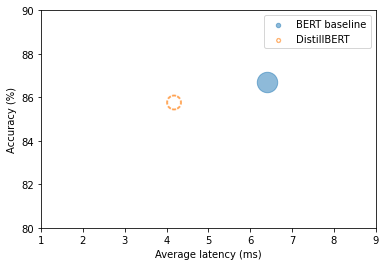

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_metrics(perf_metrics, current_optim_type):
    df = pd.DataFrame.from_dict(perf_metrics, orient='index')

    for idx in df.index:
        df_opt = df.loc[idx]
        if idx == current_optim_type:
            plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100,
                        alpha=0.5, s=df_opt["size_mb"], label=idx,
                        marker='$\u25CC$')
        else:
            plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100,
                        s =df_opt["size_mb"], label=idx, alpha=0.5)
    
    legend = plt.legend(bbox_to_anchor=(1,1))
    for handle in legend.legendHandles:
        handle.set_sizes([20])
    
    plt.ylim(80, 90)
    xlim = int(perf_metrics["BERT baseline"]["time_avg_ms"] + 3)
    plt.xlim(1, xlim)
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Average latency (ms)")
    plt.show()

plot_metrics(perf_metrics, optim_type)

In [48]:
def objective(trial):
    x = trial.suggest_float("x", -2, 2)
    y = trial.suggest_float("y", -2, 2)
    return (1 - x) ** 2 + 100 * (y - x ** 2) ** 2

In [50]:
import optuna

study = optuna.create_study()
study.optimize(objective, n_trials=1000)

[I 2022-09-25 09:07:47,174] A new study created in memory with name: no-name-356c6d5d-0999-4525-8a44-865b29f8a5a8
[I 2022-09-25 09:07:47,177] Trial 0 finished with value: 314.07050804721297 and parameters: {'x': 0.3536048565848433, 'y': -1.6459878326923456}. Best is trial 0 with value: 314.07050804721297.
[I 2022-09-25 09:07:47,178] Trial 1 finished with value: 330.0221454264095 and parameters: {'x': 1.3036196737958519, 'y': -0.11697317099723747}. Best is trial 0 with value: 314.07050804721297.
[I 2022-09-25 09:07:47,179] Trial 2 finished with value: 207.60916132739618 and parameters: {'x': -0.5891121228297385, 'y': -1.0850219186966044}. Best is trial 2 with value: 207.60916132739618.
[I 2022-09-25 09:07:47,180] Trial 3 finished with value: 266.15800981636573 and parameters: {'x': 0.009497800022193914, 'y': 1.6285155678954282}. Best is trial 2 with value: 207.60916132739618.
[I 2022-09-25 09:07:47,181] Trial 4 finished with value: 893.1457044352705 and parameters: {'x': 1.1502079970047

In [51]:
study.best_params

{'x': 1.0157192967949913, 'y': 1.0319029624649332}

In [55]:
def hp_space(trial):
    return {"num_train_epochs": trial.suggest_int("num_train_epochs", 5, 10),
        "alpha": trial.suggest_float("alpha", 0, 1),
        "temperature": trial.suggest_int("temperature", 2, 20)}

In [56]:
best_run = distilbert_trainer.hyperparameter_search(
    n_trials=20, direction="maximize", hp_space=hp_space)

[I 2022-09-25 09:08:49,761] A new study created in memory with name: no-name-ca97f372-025a-449e-a9c9-0df01d89e7c5
Trial:
loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at /home/guhangsong/.cache/huggingface/transformers/9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9ab5ee.126183e36667471617ae2f0835fab707baa54b731f991507ebbb55ea85adb12a
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing 

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.196933,0.583871
2,0.310900,0.099304,0.819355
3,0.310900,0.067301,0.876129
4,0.113300,0.052496,0.897742
5,0.075300,0.045499,0.904516
6,0.075300,0.041638,0.909355
7,0.062300,0.040449,0.910323


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to data/distilbert-base-uncased-finetuned-clinc/run-0/checkpoint-318
Configuration saved in data/distilbert-base-uncased-finetuned-clinc/run-0/checkpoint-318/config.json
Model weights saved in data/distilbert-base-uncased-finetuned-clinc/run-0/checkpoint-318/pytorch_model.bin
tokenizer config file saved in data/distilbert-base-uncased-finetuned-clinc/run-0/checkpoint-318/tokenizer_config.json
Special tokens file saved in data/distilbert-base-uncased-finetuned-clinc/run-0/checkpoint-318/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to data/distilbert-base-uncased-finetuned-clinc/run-0/checkpoint-636
Configuration saved in data/distilbert-base-uncased-finetuned-clinc/run-0/checkpoint-636/config.json
Model weights saved in data/distilbert-base-uncased-finetuned-clinc/run-0/checkpoint-636/pytorch_model.bin
tokenizer config f

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.194763,0.596452
2,0.311400,0.094897,0.834516
3,0.311400,0.062195,0.886129
4,0.108700,0.046601,0.902903
5,0.068800,0.038915,0.912903
6,0.068800,0.034047,0.920323
7,0.053700,0.030909,0.921613
8,0.046400,0.029015,0.922581
9,0.046400,0.028015,0.923548
10,0.043100,0.027515,0.923548


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to data/distilbert-base-uncased-finetuned-clinc/run-1/checkpoint-318
Configuration saved in data/distilbert-base-uncased-finetuned-clinc/run-1/checkpoint-318/config.json
Model weights saved in data/distilbert-base-uncased-finetuned-clinc/run-1/checkpoint-318/pytorch_model.bin
tokenizer config file saved in data/distilbert-base-uncased-finetuned-clinc/run-1/checkpoint-318/tokenizer_config.json
Special tokens file saved in data/distilbert-base-uncased-finetuned-clinc/run-1/checkpoint-318/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to data/distilbert-base-uncased-finetuned-clinc/run-1/checkpoint-636
Configuration saved in data/distilbert-base-uncased-finetuned-clinc/run-1/checkpoint-636/config.json
Model weights saved in data/distilbert-base-uncased-finetuned-clinc/run-1/checkpoint-636/pytorch_model.bin
tokenizer config f

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.226033,0.592903
2,0.349900,0.115703,0.812581
3,0.349900,0.080383,0.869032
4,0.132400,0.066500,0.890000
5,0.093400,0.062493,0.891935


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to data/distilbert-base-uncased-finetuned-clinc/run-2/checkpoint-318
Configuration saved in data/distilbert-base-uncased-finetuned-clinc/run-2/checkpoint-318/config.json
Model weights saved in data/distilbert-base-uncased-finetuned-clinc/run-2/checkpoint-318/pytorch_model.bin
tokenizer config file saved in data/distilbert-base-uncased-finetuned-clinc/run-2/checkpoint-318/tokenizer_config.json
Special tokens file saved in data/distilbert-base-uncased-finetuned-clinc/run-2/checkpoint-318/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to data/distilbert-base-uncased-finetuned-clinc/run-2/checkpoint-636
Configuration saved in data/distilbert-base-uncased-finetuned-clinc/run-2/checkpoint-636/config.json
Model weights saved in data/distilbert-base-uncased-finetuned-clinc/run-2/checkpoint-636/pytorch_model.bin
tokenizer config f

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.207347,0.607419
2,0.329800,0.099792,0.838710
3,0.329800,0.064722,0.888710
4,0.114600,0.048381,0.902903
5,0.072200,0.040378,0.914516
6,0.072200,0.035473,0.919032
7,0.056700,0.032576,0.920968
8,0.049600,0.030903,0.921290
9,0.049600,0.030396,0.921613


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to data/distilbert-base-uncased-finetuned-clinc/run-3/checkpoint-318
Configuration saved in data/distilbert-base-uncased-finetuned-clinc/run-3/checkpoint-318/config.json
Model weights saved in data/distilbert-base-uncased-finetuned-clinc/run-3/checkpoint-318/pytorch_model.bin
tokenizer config file saved in data/distilbert-base-uncased-finetuned-clinc/run-3/checkpoint-318/tokenizer_config.json
Special tokens file saved in data/distilbert-base-uncased-finetuned-clinc/run-3/checkpoint-318/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to data/distilbert-base-uncased-finetuned-clinc/run-3/checkpoint-636
Configuration saved in data/distilbert-base-uncased-finetuned-clinc/run-3/checkpoint-636/config.json
Model weights saved in data/distilbert-base-uncased-finetuned-clinc/run-3/checkpoint-636/pytorch_model.bin
tokenizer config f

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.198854,0.579355
2,0.311900,0.102153,0.813871
3,0.311900,0.070718,0.871613
4,0.116400,0.056692,0.892258
5,0.079800,0.050553,0.901613
6,0.079800,0.048501,0.904194


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to data/distilbert-base-uncased-finetuned-clinc/run-4/checkpoint-318
Configuration saved in data/distilbert-base-uncased-finetuned-clinc/run-4/checkpoint-318/config.json
Model weights saved in data/distilbert-base-uncased-finetuned-clinc/run-4/checkpoint-318/pytorch_model.bin
tokenizer config file saved in data/distilbert-base-uncased-finetuned-clinc/run-4/checkpoint-318/tokenizer_config.json
Special tokens file saved in data/distilbert-base-uncased-finetuned-clinc/run-4/checkpoint-318/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to data/distilbert-base-uncased-finetuned-clinc/run-4/checkpoint-636
Configuration saved in data/distilbert-base-uncased-finetuned-clinc/run-4/checkpoint-636/config.json
Model weights saved in data/distilbert-base-uncased-finetuned-clinc/run-4/checkpoint-636/pytorch_model.bin
tokenizer config f

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.296175,0.643548
2,0.464100,0.126841,0.839677
3,0.464100,0.074328,0.895484
4,0.146500,0.054073,0.905484
5,0.085200,0.045587,0.911613
6,0.085200,0.041252,0.919032
7,0.067800,0.039912,0.917742


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to data/distilbert-base-uncased-finetuned-clinc/run-5/checkpoint-318
Configuration saved in data/distilbert-base-uncased-finetuned-clinc/run-5/checkpoint-318/config.json
Model weights saved in data/distilbert-base-uncased-finetuned-clinc/run-5/checkpoint-318/pytorch_model.bin
tokenizer config file saved in data/distilbert-base-uncased-finetuned-clinc/run-5/checkpoint-318/tokenizer_config.json
Special tokens file saved in data/distilbert-base-uncased-finetuned-clinc/run-5/checkpoint-318/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to data/distilbert-base-uncased-finetuned-clinc/run-5/checkpoint-636
Configuration saved in data/distilbert-base-uncased-finetuned-clinc/run-5/checkpoint-636/config.json
Model weights saved in data/distilbert-base-uncased-finetuned-clinc/run-5/checkpoint-636/pytorch_model.bin
tokenizer config f

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.195792,0.596129
2,0.312400,0.096054,0.831613
3,0.312400,0.063475,0.883871
4,0.109900,0.047891,0.901290
5,0.070300,0.040279,0.911935
6,0.070300,0.035488,0.919032
7,0.055600,0.032646,0.920323


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to data/distilbert-base-uncased-finetuned-clinc/run-6/checkpoint-318
Configuration saved in data/distilbert-base-uncased-finetuned-clinc/run-6/checkpoint-318/config.json
Model weights saved in data/distilbert-base-uncased-finetuned-clinc/run-6/checkpoint-318/pytorch_model.bin
tokenizer config file saved in data/distilbert-base-uncased-finetuned-clinc/run-6/checkpoint-318/tokenizer_config.json
Special tokens file saved in data/distilbert-base-uncased-finetuned-clinc/run-6/checkpoint-318/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to data/distilbert-base-uncased-finetuned-clinc/run-6/checkpoint-636
Configuration saved in data/distilbert-base-uncased-finetuned-clinc/run-6/checkpoint-636/config.json
Model weights saved in data/distilbert-base-uncased-finetuned-clinc/run-6/checkpoint-636/pytorch_model.bin
tokenizer config f

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.204162,0.573226


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
[I 2022-09-25 09:26:07,623] Trial 7 pruned. 
Trial:
loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at /home/guhangsong/.cache/huggingface/transformers/9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9ab5ee.126183e36667471617ae2f0835fab707baa54b731f991507ebbb55ea85adb12a
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializin

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.289209,0.652581
2,0.459200,0.117745,0.847419
3,0.459200,0.066407,0.900968
4,0.137000,0.046886,0.908710
5,0.075800,0.038497,0.918710
6,0.075800,0.033592,0.925484
7,0.057300,0.030816,0.929355
8,0.049100,0.028948,0.930323
9,0.049100,0.028029,0.929677
10,0.045500,0.027581,0.928387


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to data/distilbert-base-uncased-finetuned-clinc/run-8/checkpoint-318
Configuration saved in data/distilbert-base-uncased-finetuned-clinc/run-8/checkpoint-318/config.json
Model weights saved in data/distilbert-base-uncased-finetuned-clinc/run-8/checkpoint-318/pytorch_model.bin
tokenizer config file saved in data/distilbert-base-uncased-finetuned-clinc/run-8/checkpoint-318/tokenizer_config.json
Special tokens file saved in data/distilbert-base-uncased-finetuned-clinc/run-8/checkpoint-318/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to data/distilbert-base-uncased-finetuned-clinc/run-8/checkpoint-636
Configuration saved in data/distilbert-base-uncased-finetuned-clinc/run-8/checkpoint-636/config.json
Model weights saved in data/distilbert-base-uncased-finetuned-clinc/run-8/checkpoint-636/pytorch_model.bin
tokenizer config f

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.224330,0.614839
2,0.354800,0.106252,0.839032
3,0.354800,0.067909,0.887742
4,0.122300,0.050646,0.901613
5,0.076400,0.042412,0.912258
6,0.076400,0.037577,0.919355
7,0.060600,0.035175,0.918710


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to data/distilbert-base-uncased-finetuned-clinc/run-9/checkpoint-318
Configuration saved in data/distilbert-base-uncased-finetuned-clinc/run-9/checkpoint-318/config.json
Model weights saved in data/distilbert-base-uncased-finetuned-clinc/run-9/checkpoint-318/pytorch_model.bin
tokenizer config file saved in data/distilbert-base-uncased-finetuned-clinc/run-9/checkpoint-318/tokenizer_config.json
Special tokens file saved in data/distilbert-base-uncased-finetuned-clinc/run-9/checkpoint-318/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to data/distilbert-base-uncased-finetuned-clinc/run-9/checkpoint-636
Configuration saved in data/distilbert-base-uncased-finetuned-clinc/run-9/checkpoint-636/config.json
Model weights saved in data/distilbert-base-uncased-finetuned-clinc/run-9/checkpoint-636/pytorch_model.bin
tokenizer config f

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.403994,0.661935
2,0.639200,0.140970,0.850000
3,0.639200,0.071176,0.904194
4,0.162900,0.050419,0.910645
5,0.080400,0.042201,0.917742
6,0.080400,0.037195,0.926452
7,0.060400,0.034728,0.928387
8,0.052000,0.032829,0.930000
9,0.052000,0.031790,0.930000
10,0.048200,0.031309,0.930000


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to data/distilbert-base-uncased-finetuned-clinc/run-10/checkpoint-318
Configuration saved in data/distilbert-base-uncased-finetuned-clinc/run-10/checkpoint-318/config.json
Model weights saved in data/distilbert-base-uncased-finetuned-clinc/run-10/checkpoint-318/pytorch_model.bin
tokenizer config file saved in data/distilbert-base-uncased-finetuned-clinc/run-10/checkpoint-318/tokenizer_config.json
Special tokens file saved in data/distilbert-base-uncased-finetuned-clinc/run-10/checkpoint-318/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to data/distilbert-base-uncased-finetuned-clinc/run-10/checkpoint-636
Configuration saved in data/distilbert-base-uncased-finetuned-clinc/run-10/checkpoint-636/config.json
Model weights saved in data/distilbert-base-uncased-finetuned-clinc/run-10/checkpoint-636/pytorch_model.bin
tokenizer 

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.403994,0.661935
2,0.639200,0.140970,0.850000
3,0.639200,0.071176,0.904194
4,0.162900,0.050419,0.910645
5,0.080400,0.042201,0.917742
6,0.080400,0.037195,0.926452
7,0.060400,0.034728,0.928387
8,0.052000,0.032829,0.930000
9,0.052000,0.031790,0.930000
10,0.048200,0.031309,0.930000


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to data/distilbert-base-uncased-finetuned-clinc/run-11/checkpoint-318
Configuration saved in data/distilbert-base-uncased-finetuned-clinc/run-11/checkpoint-318/config.json
Model weights saved in data/distilbert-base-uncased-finetuned-clinc/run-11/checkpoint-318/pytorch_model.bin
tokenizer config file saved in data/distilbert-base-uncased-finetuned-clinc/run-11/checkpoint-318/tokenizer_config.json
Special tokens file saved in data/distilbert-base-uncased-finetuned-clinc/run-11/checkpoint-318/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to data/distilbert-base-uncased-finetuned-clinc/run-11/checkpoint-636
Configuration saved in data/distilbert-base-uncased-finetuned-clinc/run-11/checkpoint-636/config.json
Model weights saved in data/distilbert-base-uncased-finetuned-clinc/run-11/checkpoint-636/pytorch_model.bin
tokenizer 

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.406611,0.659355
2,0.641100,0.144257,0.846452
3,0.641100,0.073354,0.902581
4,0.166300,0.051969,0.909355
5,0.082900,0.043680,0.917097
6,0.082900,0.038633,0.926452
7,0.062700,0.036268,0.926129
8,0.054600,0.034595,0.927742


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to data/distilbert-base-uncased-finetuned-clinc/run-12/checkpoint-318
Configuration saved in data/distilbert-base-uncased-finetuned-clinc/run-12/checkpoint-318/config.json
Model weights saved in data/distilbert-base-uncased-finetuned-clinc/run-12/checkpoint-318/pytorch_model.bin
tokenizer config file saved in data/distilbert-base-uncased-finetuned-clinc/run-12/checkpoint-318/tokenizer_config.json
Special tokens file saved in data/distilbert-base-uncased-finetuned-clinc/run-12/checkpoint-318/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to data/distilbert-base-uncased-finetuned-clinc/run-12/checkpoint-636
Configuration saved in data/distilbert-base-uncased-finetuned-clinc/run-12/checkpoint-636/config.json
Model weights saved in data/distilbert-base-uncased-finetuned-clinc/run-12/checkpoint-636/pytorch_model.bin
tokenizer 

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.199476,0.602258
2,0.318900,0.096351,0.834516


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to data/distilbert-base-uncased-finetuned-clinc/run-13/checkpoint-318
Configuration saved in data/distilbert-base-uncased-finetuned-clinc/run-13/checkpoint-318/config.json
Model weights saved in data/distilbert-base-uncased-finetuned-clinc/run-13/checkpoint-318/pytorch_model.bin
tokenizer config file saved in data/distilbert-base-uncased-finetuned-clinc/run-13/checkpoint-318/tokenizer_config.json
Special tokens file saved in data/distilbert-base-uncased-finetuned-clinc/run-13/checkpoint-318/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
[I 2022-09-25 09:41:14,012] Trial 13 pruned. 
Trial:
loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at /home/guhangsong/.cache/huggingface/transformers/9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9ab5ee.126183e36667471617ae2f0835fab707ba

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.235364,0.627419
2,0.371800,0.109331,0.842258
3,0.371800,0.068589,0.891935
4,0.125900,0.050684,0.902581


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to data/distilbert-base-uncased-finetuned-clinc/run-14/checkpoint-318
Configuration saved in data/distilbert-base-uncased-finetuned-clinc/run-14/checkpoint-318/config.json
Model weights saved in data/distilbert-base-uncased-finetuned-clinc/run-14/checkpoint-318/pytorch_model.bin
tokenizer config file saved in data/distilbert-base-uncased-finetuned-clinc/run-14/checkpoint-318/tokenizer_config.json
Special tokens file saved in data/distilbert-base-uncased-finetuned-clinc/run-14/checkpoint-318/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to data/distilbert-base-uncased-finetuned-clinc/run-14/checkpoint-636
Configuration saved in data/distilbert-base-uncased-finetuned-clinc/run-14/checkpoint-636/config.json
Model weights saved in data/distilbert-base-uncased-finetuned-clinc/run-14/checkpoint-636/pytorch_model.bin
tokenizer 

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.206232,0.607097
2,0.329000,0.098413,0.840323
3,0.329000,0.063300,0.890323
4,0.113100,0.046886,0.904839
5,0.070400,0.038857,0.915484
6,0.070400,0.033900,0.920323
7,0.054700,0.030718,0.922258


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to data/distilbert-base-uncased-finetuned-clinc/run-15/checkpoint-318
Configuration saved in data/distilbert-base-uncased-finetuned-clinc/run-15/checkpoint-318/config.json
Model weights saved in data/distilbert-base-uncased-finetuned-clinc/run-15/checkpoint-318/pytorch_model.bin
tokenizer config file saved in data/distilbert-base-uncased-finetuned-clinc/run-15/checkpoint-318/tokenizer_config.json
Special tokens file saved in data/distilbert-base-uncased-finetuned-clinc/run-15/checkpoint-318/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to data/distilbert-base-uncased-finetuned-clinc/run-15/checkpoint-636
Configuration saved in data/distilbert-base-uncased-finetuned-clinc/run-15/checkpoint-636/config.json
Model weights saved in data/distilbert-base-uncased-finetuned-clinc/run-15/checkpoint-636/pytorch_model.bin
tokenizer 

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.200813,0.599355


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
[I 2022-09-25 09:45:18,632] Trial 16 pruned. 
Trial:
loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at /home/guhangsong/.cache/huggingface/transformers/9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9ab5ee.126183e36667471617ae2f0835fab707baa54b731f991507ebbb55ea85adb12a
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializi

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.235364,0.627419
2,0.371800,0.109331,0.842258
3,0.371800,0.068589,0.891935
4,0.125900,0.050684,0.902581


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to data/distilbert-base-uncased-finetuned-clinc/run-17/checkpoint-318
Configuration saved in data/distilbert-base-uncased-finetuned-clinc/run-17/checkpoint-318/config.json
Model weights saved in data/distilbert-base-uncased-finetuned-clinc/run-17/checkpoint-318/pytorch_model.bin
tokenizer config file saved in data/distilbert-base-uncased-finetuned-clinc/run-17/checkpoint-318/tokenizer_config.json
Special tokens file saved in data/distilbert-base-uncased-finetuned-clinc/run-17/checkpoint-318/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to data/distilbert-base-uncased-finetuned-clinc/run-17/checkpoint-636
Configuration saved in data/distilbert-base-uncased-finetuned-clinc/run-17/checkpoint-636/config.json
Model weights saved in data/distilbert-base-uncased-finetuned-clinc/run-17/checkpoint-636/pytorch_model.bin
tokenizer 

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.403994,0.661935
2,0.639200,0.140970,0.850000
3,0.639200,0.071176,0.904194
4,0.162900,0.050419,0.910645
5,0.080400,0.042201,0.917742
6,0.080400,0.037195,0.926452
7,0.060400,0.034728,0.928387
8,0.052000,0.032829,0.930000
9,0.052000,0.031790,0.930000
10,0.048200,0.031309,0.930000


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to data/distilbert-base-uncased-finetuned-clinc/run-18/checkpoint-318
Configuration saved in data/distilbert-base-uncased-finetuned-clinc/run-18/checkpoint-318/config.json
Model weights saved in data/distilbert-base-uncased-finetuned-clinc/run-18/checkpoint-318/pytorch_model.bin
tokenizer config file saved in data/distilbert-base-uncased-finetuned-clinc/run-18/checkpoint-318/tokenizer_config.json
Special tokens file saved in data/distilbert-base-uncased-finetuned-clinc/run-18/checkpoint-318/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to data/distilbert-base-uncased-finetuned-clinc/run-18/checkpoint-636
Configuration saved in data/distilbert-base-uncased-finetuned-clinc/run-18/checkpoint-636/config.json
Model weights saved in data/distilbert-base-uncased-finetuned-clinc/run-18/checkpoint-636/pytorch_model.bin
tokenizer 

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.210892,0.610645
2,0.335300,0.100881,0.838710
3,0.335300,0.065050,0.889355
4,0.116000,0.048468,0.903226
5,0.072700,0.040366,0.914516
6,0.072700,0.035424,0.919032


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to data/distilbert-base-uncased-finetuned-clinc/run-19/checkpoint-318
Configuration saved in data/distilbert-base-uncased-finetuned-clinc/run-19/checkpoint-318/config.json
Model weights saved in data/distilbert-base-uncased-finetuned-clinc/run-19/checkpoint-318/pytorch_model.bin
tokenizer config file saved in data/distilbert-base-uncased-finetuned-clinc/run-19/checkpoint-318/tokenizer_config.json
Special tokens file saved in data/distilbert-base-uncased-finetuned-clinc/run-19/checkpoint-318/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to data/distilbert-base-uncased-finetuned-clinc/run-19/checkpoint-636
Configuration saved in data/distilbert-base-uncased-finetuned-clinc/run-19/checkpoint-636/config.json
Model weights saved in data/distilbert-base-uncased-finetuned-clinc/run-19/checkpoint-636/pytorch_model.bin
tokenizer 

In [58]:
print(best_run)

BestRun(run_id='10', objective=0.93, hyperparameters={'num_train_epochs': 10, 'alpha': 0.4578114064764249, 'temperature': 2})


In [60]:
for k, v in best_run.hyperparameters.items():
    setattr(student_training_args, k, v)

distilled_ckpt = "data/distillbert-base-uncased-distilled-clinc"
student_training_args.output_dir = distilled_ckpt

distill_trainer = DistillationTrainer(model_init=student_init,
    teacher_model=teacher_model, args=student_training_args,
    train_dataset=clinc_enc['train'], eval_dataset=clinc_enc['validation'],
    compute_metrics=compute_metrics, tokenizer=student_tokenizer)

distilbert_trainer.train()

loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at /home/guhangsong/.cache/huggingface/transformers/9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9ab5ee.126183e36667471617ae2f0835fab707baa54b731f991507ebbb55ea85adb12a
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing 

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.713752,0.741613
2,2.072100,0.867878,0.858387
3,2.072100,0.507208,0.910323
4,0.786300,0.373459,0.936774
5,0.373300,0.326915,0.943871
6,0.373300,0.304613,0.948065
7,0.266700,0.293774,0.947419
8,0.232300,0.288233,0.947742
9,0.232300,0.286316,0.948710
10,0.220600,0.284721,0.948387


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to data/distillbert-base-uncased-distilled-clinc/checkpoint-318
Configuration saved in data/distillbert-base-uncased-distilled-clinc/checkpoint-318/config.json
Model weights saved in data/distillbert-base-uncased-distilled-clinc/checkpoint-318/pytorch_model.bin
tokenizer config file saved in data/distillbert-base-uncased-distilled-clinc/checkpoint-318/tokenizer_config.json
Special tokens file saved in data/distillbert-base-uncased-distilled-clinc/checkpoint-318/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to data/distillbert-base-uncased-distilled-clinc/checkpoint-636
Configuration saved in data/distillbert-base-uncased-distilled-clinc/checkpoint-636/config.json
Model weights saved in data/distillbert-base-uncased-distilled-clinc/checkpoint-636/pytorch_model.bin
tokenizer config file saved in data/distillbert-base-uncas

TrainOutput(global_step=3180, training_loss=0.6335120686944925, metrics={'train_runtime': 199.2041, 'train_samples_per_second': 765.547, 'train_steps_per_second': 15.964, 'total_flos': 933776874167172.0, 'train_loss': 0.6335120686944925, 'epoch': 10.0})

In [25]:
distilled_ckpt = "data/distillbert-base-uncased-distilled-clinc/checkpoint-3180"
pipe = pipeline("text-classification", model=distilled_ckpt, device=0)
optim_type = "Distillation"
pb = PerformanceBenchMark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 255.89


/opt/miniconda3/envs/pytorch/lib/python3.9/site-packages/transformers/pipelines/base.py:1036: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Average latency (ms) - 4.06 +\- 1.51
Accuracy on test set - 0.878


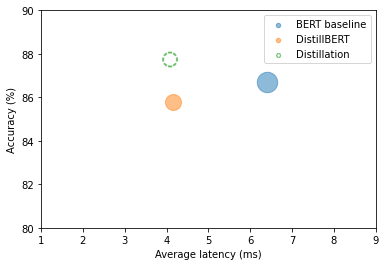

In [26]:
plot_metrics(perf_metrics, optim_type)

## Quantization

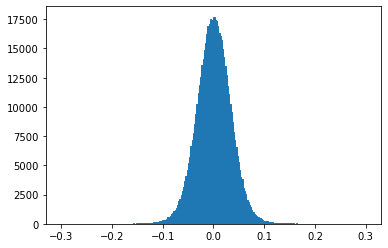

In [63]:
state_dict = pipe.model.state_dict()
weights = state_dict["distilbert.transformer.layer.0.attention.out_lin.weight"]
plt.hist(weights.flatten().numpy(), bins=250, range=(-0.3,0.3), edgecolor="C0")
plt.show()

In [64]:
zero_point = 0
scale = (weights.max() - weights.min()) / (127 - (-128))
(weights / scale + zero_point).clamp(-128, 127).round().char()

tensor([[ -5,  -7,   0,  ...,  -6,  -4,   8],
        [  9,   2,   1,  ...,  -4,   7,   0],
        [ -9,  -6,   5,  ...,   0,   5,  -4],
        ...,
        [  5,   0,  12,  ...,   0,   6,  -1],
        [  0,  -2, -12,  ...,  12,  -7, -13],
        [-13,  -1,  -9,  ...,   8,   2,  -2]], dtype=torch.int8)

In [65]:
from torch import quantize_per_tensor

dtype = torch.qint8
quantized_weights = quantize_per_tensor(weights, scale, zero_point, dtype)
quantized_weights.int_repr()

tensor([[ -5,  -7,   0,  ...,  -6,  -4,   8],
        [  9,   2,   1,  ...,  -4,   7,   0],
        [ -9,  -6,   5,  ...,   0,   5,  -4],
        ...,
        [  5,   0,  12,  ...,   0,   6,  -1],
        [  0,  -2, -12,  ...,  12,  -7, -13],
        [-13,  -1,  -9,  ...,   8,   2,  -2]], dtype=torch.int8)

In [66]:
%%timeit
weights @ weights

1.35 ms ± 7.69 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [67]:
from torch.nn.quantized import QFunctional
q_fn = QFunctional()

In [68]:
%%timeit
q_fn.mul(quantized_weights, quantized_weights)

31.6 µs ± 552 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [69]:
import sys
sys.getsizeof(weights.storage()) / sys.getsizeof(quantized_weights.storage())

3.999755879241598

In [41]:
from torch.quantization import quantize_dynamic
model_ckpt = "data/distillbert-base-uncased-distilled-clinc/checkpoint-3180"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = (AutoModelForSequenceClassification
        .from_pretrained(model_ckpt).to("cpu"))
model_quantized = quantize_dynamic(model, {nn.Linear}, dtype=torch.qint8)

NameError: name 'AutoModelForSequenceClassification' is not defined

In [71]:
pipe = pipeline("text-classification", model=model_quantized,
            tokenizer=tokenizer)
optim_type = "Distillation + quantization"
pb = PerformanceBenchMark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 132.40
Average latency (ms) - 5.80 +\- 0.68
Accuracy on test set - 0.884


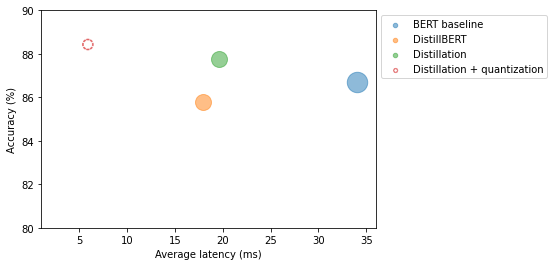

In [72]:
plot_metrics(perf_metrics, optim_type)

## ONNX

In [73]:
import os
from psutil import cpu_count

os.environ["OMP_NUM_THREADS"] = f"{cpu_count()}"
os.environ["OMP_WAIT_POLICY"] = "ACTIVE"

In [29]:
from transformers.convert_graph_to_onnx import convert

model_ckpt = "data/distillbert-base-uncased-distilled-clinc/checkpoint-3180"
onnx_model_path = Path("data/onnx/model.onnx")
convert(framework="pt", model=model_ckpt, tokenizer=tokenizer,
        output=onnx_model_path, opset=12, pipeline_name="text-classification")

NameError: name 'tokenizer' is not defined

In [35]:
from onnxruntime import GraphOptimizationLevel, InferenceSession, SessionOptions

def create_model_for_provider(model_path, provider="CPUExecutionProvider"):
    options = SessionOptions()
    options.intra_op_num_threads = 1
    options.graph_optimization_level = GraphOptimizationLevel.ORT_ENABLE_ALL
    session = InferenceSession(str(model_path), options, providers=provider)
    session.disable_fallback()
    return session

providers = [
    ('CUDAExecutionProvider', {
        'device_id': 0,
        'arena_extend_strategy': 'kNextPowerOfTwo',
        'gpu_mem_limit': 2 * 1024 * 1024 * 1024,
        'cudnn_conv_algo_search': 'EXHAUSTIVE',
        'do_copy_in_default_stream': True,
    }),
    'CPUExecutionProvider',
]
onnx_model = create_model_for_provider(onnx_model_path, provider=providers)

In [77]:
inputs = clinc_enc["test"][:1]
del inputs["labels"]
logits_onnx = onnx_model.run(None, inputs)[0]
logits_onnx.shape

(1, 151)

In [78]:
np.argmax(logits_onnx)

61

In [79]:
clinc_enc["test"][0]["labels"]

61

In [37]:
from scipy.special import softmax

class OnnxPipeline:
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer
    
    def __call__(self, query):
        model_inputs = self.tokenizer(query, return_tensors="pt")
        inputs_onnx = {k: v.cpu().detach().numpy()
                        for k, v in model_inputs.items()}
        logits = self.model.run(None, inputs_onnx)[0][0, :]
        probs = softmax(logits)
        pred_idx = np.argmax(probs).item()
        return [{"label": intents.int2str(pred_idx), "score": probs[pred_idx]}]

In [42]:
pipe = OnnxPipeline(onnx_model, tokenizer)
pipe(query)

[{'label': 'car_rental', 'score': 0.84260464}]

In [43]:
class OnnxPerformanceBenchmark(PerformanceBenchMark):
    def __init__(self, *args, model_path, **kwargs):
        super().__init__(*args, **kwargs)
        self.model_path = model_path
    
    def compute_size(self):
        size_mb = Path(self.model_path).stat().st_size / (1024 * 1024)
        print(f"Model size (MB) - {size_mb:.2f}")
        return {"size_mb": size_mb}

In [44]:
optim_type = "Distillation + ORT"
pb = OnnxPerformanceBenchmark(pipe, clinc["test"], optim_type, model_path="data/onnx/model.onnx")
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 255.90
Average latency (ms) - 12.49 +\- 0.83
Accuracy on test set - 0.878


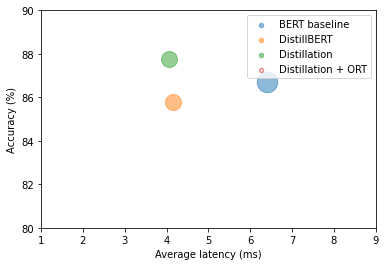

In [45]:
plot_metrics(perf_metrics, optim_type)

In [46]:
from onnxruntime.quantization import quantize_dynamic, QuantType

model_input = "data/onnx/model.onnx"
model_output = "data/onnx/model.quant.onnx"
quantize_dynamic(model_input, model_output, weight_type=QuantType.QInt8)

ModuleNotFoundError: No module named 'onnxruntime.quantization'

In [87]:
onnx_quantized_model = create_model_for_provider(model_output)
pipe = OnnxPipeline(onnx_quantized_model, tokenizer)
optim_type = "Distillation + ORT (quantized)"
pb = OnnxPerformanceBenchmark(pipe, clinc["test"], optim_type, model_path=model_output)
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 64.22
Average latency (ms) - 5.92 +\- 0.49
Accuracy on test set - 0.885


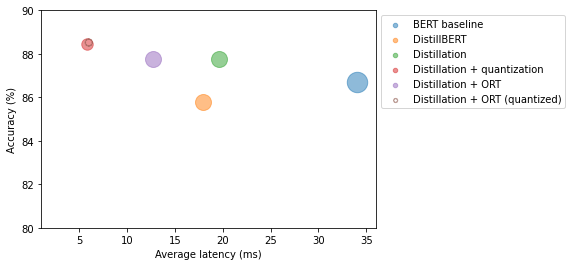

In [88]:
plot_metrics(perf_metrics, optim_type)

## Pruning

## TensorRT

In [89]:
batch_size = 48

finetuned_ckpt = "distilbert-base-uncased-tensorrt-clinc"
student_training_args = DistillationTrainingArguments(
    output_dir=f"data/{finetuned_ckpt}", evaluation_strategy = "epoch",
    num_train_epochs=5, learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size, alpha=1,
    report_to="none", weight_decay=0.01, save_strategy="epoch",
    torchdynamo="fx2trt"
)

PyTorch: setting up devices


In [90]:
tensorrt_trainer = DistillationTrainer(model_init=student_init,
    teacher_model=teacher_model, args=student_training_args,
    train_dataset=clinc_enc['train'], eval_dataset=clinc_enc['validation'],
    compute_metrics=compute_metrics, tokenizer=student_tokenizer)

tensorrt_trainer.train()

loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at /home/guhangsong/.cache/huggingface/transformers/9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9ab5ee.126183e36667471617ae2f0835fab707baa54b731f991507ebbb55ea85adb12a
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing 

RuntimeError: Torchdynamo is not installed.